In [159]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Seasonal Data

In [558]:
df_all = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_15_16.csv')

In [559]:
if type(df_all.day_of_week[0]) != int:
    df_all = day_of_week_col(df_all)

In [560]:
df_all.tail()

,away_WP,to_WP,day_of_week,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot
date,,,,,,,,,,,,,,,,
2016-04-22,NaN,NaN,4,NaN,1.4,63.5,67.0,6.5,48.5,279.7,9.8,2.8,4.2,5.6,7,8.4
2016-04-23,NaN,NaN,5,NaN,1.4,76.5,105.5,9.0,74.0,281.1,9.8,2.8,4.2,5.6,7,8.4
2016-04-24,NaN,NaN,6,NaN,1.4,83.0,104.5,9.0,73.5,282.5,9.8,2.8,4.2,5.6,7,8.4
2016-04-25,NaN,NaN,0,NaN,1.4,73.5,99.0,9.0,69.5,283.9,9.8,2.8,4.2,5.6,7,8.4
2016-04-26,NaN,NaN,1,NaN,1.4,74.5,96.0,9.0,67.5,285.3,9.8,2.8,4.2,5.6,7,8.4


#### Create a crowd yesterday column

In [561]:
#df_all['crowd_yest'] = df_all.skiers.shift(1)

#### Create dummy variables for days of the week.

In [562]:
df_all = pd.concat([df_all, pd.get_dummies(df_all.day_of_week, prefix='day')], axis=1)

#### Make midweek column and delete midweek days of code.

In [563]:
df_all = make_midweek_col(df_all)
df_all.drop(['day_1', 'day_2', 'day_3'], axis=1, inplace=True)

In [564]:
df_all.head()

,away_WP,to_WP,day_of_week,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,...,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot,day_0,day_4,day_5,day_6,midweek
date,,,,,,,,,,,,,,,,,,,,,
2015-11-15,NaN,NaN,6,NaN,1.3,18.0,2.50,2.25,2.25,1.3,...,1.3,3.9,5.2,6.5,7.8,0,0,0,1,0
2015-11-16,NaN,NaN,0,NaN,1.3,18.0,3.00,2.50,2.50,2.6,...,2.6,3.9,5.2,6.5,7.8,1,0,0,0,0
2015-11-17,NaN,NaN,1,NaN,1.3,19.5,3.25,2.50,2.75,3.9,...,2.6,3.9,5.2,6.5,7.8,0,0,0,0,1
2015-11-18,NaN,NaN,2,NaN,1.3,18.0,3.75,2.50,2.00,5.2,...,2.6,3.9,5.2,6.5,7.8,0,0,0,0,1
2015-11-19,NaN,NaN,3,NaN,1.3,18.0,6.60,2.60,2.80,6.5,...,2.6,3.9,5.2,6.5,7.8,0,0,0,0,1


### Drop day of week column

In [565]:
df_all = df_all.drop(['day_of_week'], axis=1)

#### Make month column

In [566]:
df_all['month'] = df_all.index.month

In [567]:
df_all = pd.concat([df_all, pd.get_dummies(df_all.month, prefix='month')], axis=1)

In [568]:
df_all.drop(['month'], axis=1, inplace=True)

#### Make holiday features

In [569]:
L = len(df_all)-1
holidays = get_holiday_list(df_all.index[0].year, df_all.index[0].month, df_all.index[0].day, df_all.index[L].year, df_all.index[L].month, df_all.index[L].day)

In [570]:
holidays

[Timestamp('2015-11-11 00:00:00'),
 Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-01-18 00:00:00'),
 Timestamp('2016-02-15 00:00:00')]

In [571]:
vet_day, thanksgiv, xmas, mlk_day, pres_day = get_holiday_names(holidays)

In [572]:
df_try = call_make_holiday_columns(df_all, vet_day, thanksgiv, xmas, mlk_day, pres_day)

#### Create (holiday)(weekend) and (holiday)(fri/mon/weekday) features

In [573]:
df_all['xmas_sat'] = df_all.filter(regex="day_5")*df_all.xmas
df_all['mlk_sat'] = df_all.filter(regex="day_5")*df_all.mlk_day

In [574]:
df_all['xmas_sun'] = df_all.filter(regex="day_6")*df_all.xmas
df_all['mlk_sun'] = df_all.filter(regex="day_6")*df_all.mlk_day

In [575]:
df_all['xmas_fri'] = df_all.filter(regex="day_4")*df_all.xmas
df_all['mlk_fri'] = df_all.filter(regex="day_4")*df_all.mlk_day

In [576]:
df_all['xmas_mon'] = df_all.filter(regex="day_0")*df_all.xmas
df_all['mlk_mon'] = df_all.filter(regex="day_0")*df_all.mlk_day

### Make spring break column

In [577]:
df_all = make_spring_break_col(df_all, holidays, 'hol_name')

In [578]:
df_all = make_spring_trailing_weeks(df_all, holidays, 'hol_name')

#### Make squared, cubed, square root, and log features

In [579]:
def make_squared(df, features):
    for feat1 in features:
        df[feat1 + '_sq'] = df[feat1]**2
        df[feat1 + '_cu'] = df[feat1]**3
        df[feat1 + '_sqrt'] = np.sqrt(df[feat1])
        #df['ln_' + feat1] = np.log(df[feat1])
    return df

In [580]:
features = list(df_all.columns.values)
leave_out = ['skiers', 'away_WP', 'to_WP']
features = [f for f in features if f not in leave_out]
df_all = make_squared(df_all, features)

In [581]:
df_all.head()

,away_WP,to_WP,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,...,xmas_mon_sqrt,mlk_mon_sq,mlk_mon_cu,mlk_mon_sqrt,spring_break_sq,spring_break_cu,spring_break_sqrt,spring_break_ends_sq,spring_break_ends_cu,spring_break_ends_sqrt
date,,,,,,,,,,,,,,,,,,,,,
2015-11-15,NaN,NaN,NaN,1.3,18.0,2.50,2.25,2.25,1.3,9.1,...,0,0,0,0,0,0,0,0,0,0
2015-11-16,NaN,NaN,NaN,1.3,18.0,3.00,2.50,2.50,2.6,9.1,...,0,0,0,0,0,0,0,0,0,0
2015-11-17,NaN,NaN,NaN,1.3,19.5,3.25,2.50,2.75,3.9,9.1,...,0,0,0,0,0,0,0,0,0,0
2015-11-18,NaN,NaN,NaN,1.3,18.0,3.75,2.50,2.00,5.2,9.1,...,0,0,0,0,0,0,0,0,0,0
2015-11-19,NaN,NaN,NaN,1.3,18.0,6.60,2.60,2.80,6.5,9.1,...,0,0,0,0,0,0,0,0,0,0


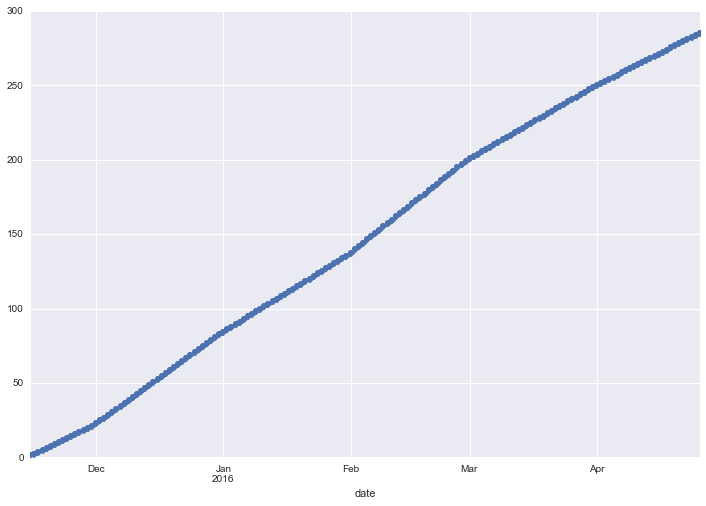

In [582]:
df_all.tot_snow.plot(linestyle='', marker='o')

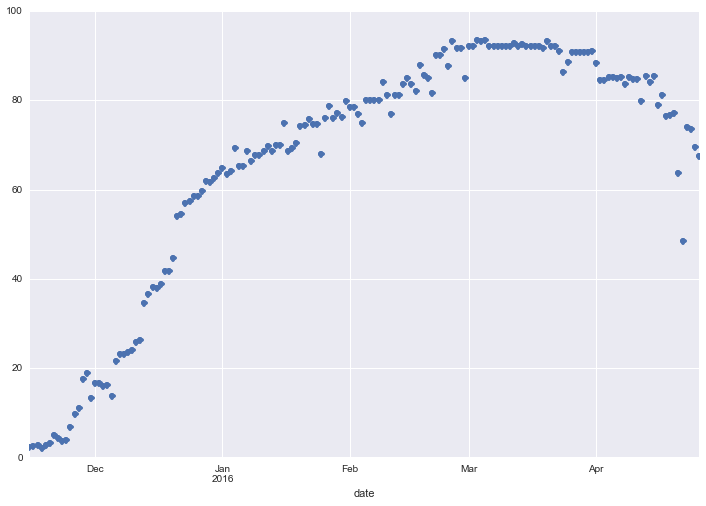

In [583]:
df_all.open_percent.plot(linestyle='', marker='o')

# Export Data

In [584]:
df_all.to_csv('../data_ski_in_solitude/data_with_features/all_15_16_feat.csv')

In [587]:
df_11 = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_11_12_feat.csv')
df_12 = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_12_13_feat.csv')
df_13 = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_13_14_feat.csv')
df_14 = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_14_15_feat.csv')
df_15 = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_15_16_feat.csv')

In [593]:
df_final = pd.concat([df_11, df_12, df_13, df_14, df_15], axis=0)

In [594]:
df_final.to_csv('../data_ski_in_solitude/data_with_features/all_feat.csv')